In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Length based data

1336001
inputX.shape (2001, 100)
input shape: n_data, n_p, n_features =  torch.Size([100, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([100, 2001])
rel. error is  0.054395
rel. error is  0.02668415


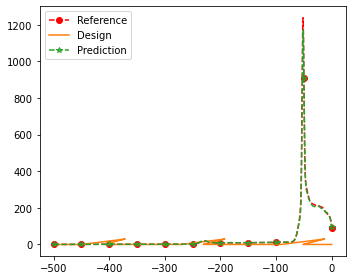

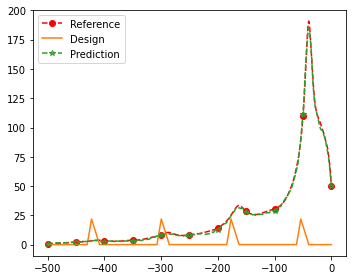

In [3]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"

n_data = 300
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]

N_s, L_x = 2001, 500


# PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
# INPUT_INFO = PATH+"data_info.npy"
# dataInfo = np.load(INPUT_INFO)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

print(count_params(model))


ntest = 100


modes = 64
width = 64
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

x_test = input.reshape(ntest, s, 2) 
y_test = output 


for sample_id in [0,8]:
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, sample_id]
    mesh = x_test[sample_id, :, :]
    
    y_test_pred = torch.exp(model(x_test[sample_id:sample_id+1,:,:].to(device))).detach().cpu().numpy().flatten()
    print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
    xx = np.linspace(-L_x, 0 ,N_s)
    plt.figure(figsize=(5,4))
    
    
    
    
    
    plt.plot(xx, y_test[sample_id, :], "--o", color="red", markevery=len(xx)//10, label="Reference")
    
    
    plt.plot(mesh[:, 0], mesh[:, 1], color="C1", label="Design")
    plt.plot(xx, y_test_pred, "--*", color="C2", fillstyle='none', markevery=len(xx)//10, label="Prediction")
#     plt.title("uf,x2,x3,h = "+str(format(uf, '.2f'))+" "
#                              +str(format(x2, '.2f'))+" "
#                              +str(format(x3, '.2f'))+" "
#                              +str(format(h, '.2f')))
    plt.legend()
    plt.tight_layout()
    plt.savefig("Validation."+str(sample_id)+".pdf")


In [ ]:
# Design shape

